source code:
https://github.com/scikit-image/scikit-image/blob/v0.13.1/skimage/feature/register_translation.py#L109

In [10]:
import numpy as np
import matplotlib.pylab as plt
from glob import glob

In [273]:
from strechablescorr import crop
from skimage.feature import register_translation
from scipy.fft import fftshift

In [274]:
def _upsampled_dft(data, upsampled_region_size,
                   upsample_factor=1, axis_offsets=None):
    """
    Upsampled DFT by matrix multiplication.
    This code is intended to provide the same result as if the following
    operations were performed:
        - Embed the array "data" in an array that is ``upsample_factor`` times
          larger in each dimension.  ifftshift to bring the center of the
          image to (1,1).
        - Take the FFT of the larger array.
        - Extract an ``[upsampled_region_size]`` region of the result, starting
          with the ``[axis_offsets+1]`` element.
    It achieves this result by computing the DFT in the output array without
    the need to zeropad. Much faster and memory efficient than the zero-padded
    FFT approach if ``upsampled_region_size`` is much smaller than
    ``data.size * upsample_factor``.
    Parameters
    ----------
    data : 2D ndarray
        The input data array (DFT of original data) to upsample.
    upsampled_region_size : integer or tuple of integers, optional
        The size of the region to be sampled.  If one integer is provided, it
        is duplicated up to the dimensionality of ``data``.
    upsample_factor : integer, optional
        The upsampling factor.  Defaults to 1.
    axis_offsets : tuple of integers, optional
        The offsets of the region to be sampled.  Defaults to None (uses
        image center)
    Returns
    -------
    output : 2D ndarray
            The upsampled DFT of the specified region.
    """
    # if people pass in an integer, expand it to a list of equal-sized sections
    if not hasattr(upsampled_region_size, "__iter__"):
        upsampled_region_size = [upsampled_region_size, ] * data.ndim
    else:
        if len(upsampled_region_size) != data.ndim:
            raise ValueError("shape of upsampled region sizes must be equal "
                             "to input data's number of dimensions.")

    if axis_offsets is None:
        axis_offsets = [0, ] * data.ndim
    else:
        if len(axis_offsets) != data.ndim:
            raise ValueError("number of axis offsets must be equal to input "
                             "data's number of dimensions.")

    col_kernel = np.exp(
        (-1j * 2 * np.pi / (data.shape[1] * upsample_factor)) *
        (np.fft.ifftshift(np.arange(data.shape[1]))[:, None] -
         np.floor(data.shape[1] / 2)).dot(
             np.arange(upsampled_region_size[1])[None, :] - axis_offsets[1])
    )
    row_kernel = np.exp(
        (-1j * 2 * np.pi / (data.shape[0] * upsample_factor)) *
        (np.arange(upsampled_region_size[0])[:, None] - axis_offsets[0]).dot(
            np.fft.ifftshift(np.arange(data.shape[0]))[None, :] -
            np.floor(data.shape[0] / 2))
    )

    return row_kernel.dot(data).dot(col_kernel)

In [275]:
def norm(I):
    return ( I - np.mean(I) )/ I.std()

In [279]:
# 1-step traversal
def one_step_traversal(ij_center, window_half_size, upsample_factor):
    dx, dy = [], []
    xy = [ij_center, ]
    for k in range(cube.shape[2] - 1):
        ij_center_k = xy[-1]
        I = crop(cube[:, :, k],   ij_center_k, window_half_size)
        J = crop(cube[:, :, k+1], ij_center_k, window_half_size)

        if I.shape[0] != I.shape[1]:
            break
        shifts, error, _ = register_translation(I, J,
                                                upsample_factor=upsample_factor)
        dx.append(-shifts[0])
        dy.append(-shifts[1])
        xy.append( (ij_center_k[0] - shifts[0], ij_center_k[1] - shifts[1]) )

    dx = np.array(dx)
    dy = np.array(dy)

    return xy

In [280]:
possible_path = glob('output/*/cube.npy')
print(possible_path)

path = possible_path[0]
cube = np.load( path )
print(cube.shape, path)

['output/hpr1/cube.npy', 'output/HS2/cube.npy']
(1024, 1392, 25) output/hpr1/cube.npy


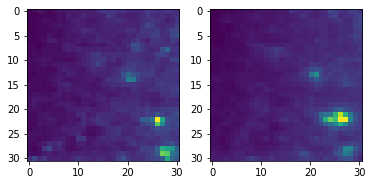

In [285]:
ij_center = (520, 230)
window_half_size = 15
upsample_factor = 10

xy1 = one_step_traversal(ij_center, window_half_size, upsample_factor)

k, step = 0, 10
I = crop(cube[:, :, k],  xy1[k], window_half_size)
J = crop(cube[:, :, k+step], xy1[k+step], window_half_size)

I = norm(I)
J = norm( norm(J) + .001*np.random.randn(*J.shape) )

plt.subplot(1, 2, 1);
plt.imshow(I);
plt.subplot(1, 2, 2);
plt.imshow(J); 

shifts [1. 0.]


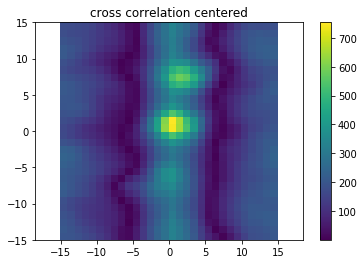

In [286]:
# FFT
src_image = np.array(I, dtype=np.complex128, copy=False)
target_image = np.array(J, dtype=np.complex128, copy=False)
src_freq = np.fft.fftn(src_image)
target_freq = np.fft.fftn(target_image)

# Whole-pixel shift - Compute cross-correlation by an IFFT
shape = src_freq.shape
image_product = src_freq * target_freq.conj()
cross_correlation = np.fft.ifftn(image_product)

# Locate maximum
maxima = np.unravel_index(np.argmax(np.abs(cross_correlation)),
                          cross_correlation.shape)
midpoints = np.array([np.fix(axis_size / 2) for axis_size in shape])

shifts = np.array(maxima, dtype=np.float64)
print('shifts', shifts)

# Graph
cross_correlation_centered = fftshift(cross_correlation, axes=None)
size = cross_correlation_centered.shape[0]
dx_span = list( np.arange( size ) - size//2 )
plt.pcolormesh(dx_span, dx_span, np.abs( cross_correlation_centered ));
plt.axis('equal'); plt.colorbar(); plt.title('cross correlation centered');

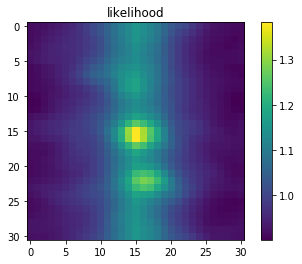

In [287]:
sigma = 2.2*size
likelihood = np.exp( 2/sigma**2 * np.real( cross_correlation_centered ) )
 
plt.imshow(likelihood); plt.title('likelihood'); plt.colorbar();

In [288]:
# Expected value

mdf = likelihood/np.sum(likelihood)

X, Y = np.meshgrid(dx_span, dx_span) 

x0 = np.sum(X*mdf)
y0 = np.sum(Y*mdf)

x0, y0

(-0.02228913323727849, 0.021390736125364018)

5.175649480042353e-17 0.6668244752783776


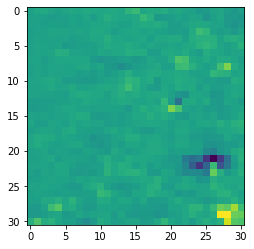

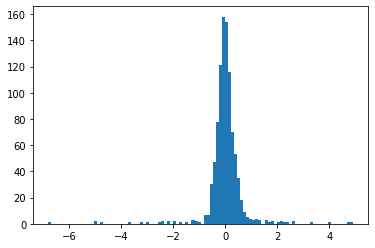

In [289]:
delta_I_J = (I-J)
plt.imshow(delta_I_J)
print(delta_I_J.mean(), delta_I_J.std())
plt.figure();
plt.hist( np.ravel(delta_I_J), bins=100);

In [292]:
# Initial shift estimate in upsampled grid
shifts = np.round(shifts * upsample_factor) / upsample_factor
upsampled_region_size = np.ceil(upsample_factor * 20)# 1.5)
# Center of output array at dftshift + 1
dftshift = np.fix(upsampled_region_size / 2.0)
upsample_factor = np.array(upsample_factor, dtype=np.float64)
normalization = (src_freq.size * upsample_factor ** 2)
# Matrix multiply DFT around the current shift estimate
sample_region_offset = dftshift - shifts*upsample_factor
cross_correlation = _upsampled_dft(image_product.conj(),
                                   upsampled_region_size,
                                   upsample_factor,
                                   sample_region_offset).conj()
cross_correlation /= normalization
# Locate maximum and map back to original pixel grid
maxima = np.array(np.unravel_index(
                      np.argmax(np.abs(cross_correlation)),
                      cross_correlation.shape),
                  dtype=np.float64)
maxima -= dftshift
shifts = shifts + maxima / upsample_factor
print(shifts)


[0.5 0. ]


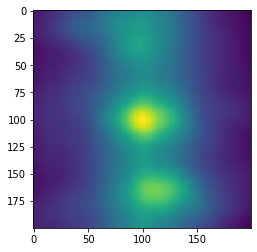

In [293]:
plt.imshow(np.real( cross_correlation ))

In [206]:
CCmax = cross_correlation.max()
src_amp = _upsampled_dft(src_freq * src_freq.conj(),
                         1, upsample_factor)[0, 0]
src_amp /= normalization
target_amp = _upsampled_dft(target_freq * target_freq.conj(),
                            1, upsample_factor)[0, 0]
target_amp /= normalization